# Import the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# import needed python libraries

%matplotlib inline

from itertools import product
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_validate

# read data
ddos_data = pd.read_csv("drive/MyDrive/ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

# set Flow ID
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' +
                         ddos_data['Destination Port'].astype(str) + ' - ' +
                         ddos_data['Timestamp'].astype(str) )
ddos_data = ddos_data.set_index("Flow ID")

#  categorical SimillarHTTP
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes

# delete rubbish
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

# delete varancie null
variance = ddos_data.var(numeric_only=True)
zero_variance = variance[variance == 0].index
ddos_data.drop(zero_variance, axis=1, inplace=True)

# one-hot encode Protocol
mask_udp = ddos_data['Protocol'] == 0
mask_tcp = ddos_data['Protocol'] == 6
mask_hopopt = ddos_data['Protocol'] == 17
ddos_data['Protocol 0'] = mask_udp.astype(int)
ddos_data['Protocol 6'] = mask_tcp.astype(int)
ddos_data['Protocol 17'] = mask_hopopt.astype(int)

# encode Port
frequencies = ddos_data['Destination Port'].value_counts()
ddos_data['Destination Port Freq'] = ddos_data['Destination Port'].map(frequencies)
frequencies = ddos_data['Source Port'].value_counts()
ddos_data['Source Port Freq'] = ddos_data['Source Port'].map(frequencies)

# delete features
ddos_data.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol"],
    axis=1,
    inplace=True)


# features selected in the first section
columns_to_remove = ['Active Max', 'Active Min', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Protocol 17', 'Protocol 6', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = ddos_data.drop(columns=columns_to_remove)
ddos_data.columns

# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set

ddos_data_temp = ddos_data.copy()
ddos_data_temp['label'] = pd.Categorical(ddos_data_temp['label']).codes

x = ddos_data_temp.drop(columns=['label'])
y = ddos_data_temp[['label']]

# Run stratified training-test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.7, random_state=15)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# Standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_s, x_test_s = scaler.transform(x_train), scaler.transform(x_test)

# Logistic Regression

## Training with default parameters


In [ ]:
# Initialize the models with default parameters
logistic_regression = LogisticRegression(n_jobs=-1,random_state=42)

# Train the models on the training data
logistic_regression.fit(x_train_s, y_train)

# Evaluate the models on the training set
y_train_pred_lr = logistic_regression.predict(x_train_s)

# Evaluate the models on the test set
y_test_pred_lr = logistic_regression.predict(x_test_s)

In [ ]:
def plot_confusion_matrix_and_report(y_true, y_pred, model_name, dataset_type):
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, cbar_kws={'label': 'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{model_name} - {dataset_type} - Confusion matrix')
    os.makedirs('plots', exist_ok=True)  # Create a directory to store the plots if it doesn't exist
    plt.savefig(f'plots/{model_name}_{dataset_type}_confusion_matrix.png')
    plt.show()
    print(classification_report(y_true, y_pred))

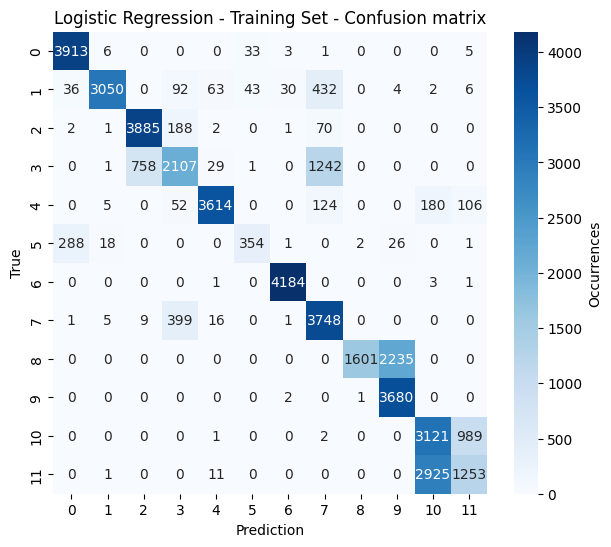

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3961
           1       0.99      0.81      0.89      3758
           2       0.84      0.94      0.88      4149
           3       0.74      0.51      0.60      4138
           4       0.97      0.89      0.92      4081
           5       0.82      0.51      0.63       690
           6       0.99      1.00      0.99      4189
           7       0.67      0.90      0.77      4179
           8       1.00      0.42      0.59      3836
           9       0.62      1.00      0.76      3683
          10       0.50      0.76      0.60      4113
          11       0.53      0.30      0.38      4190

    accuracy                           0.77     44967
   macro avg       0.80      0.75      0.75     44967
weighted avg       0.80      0.77      0.76     44967



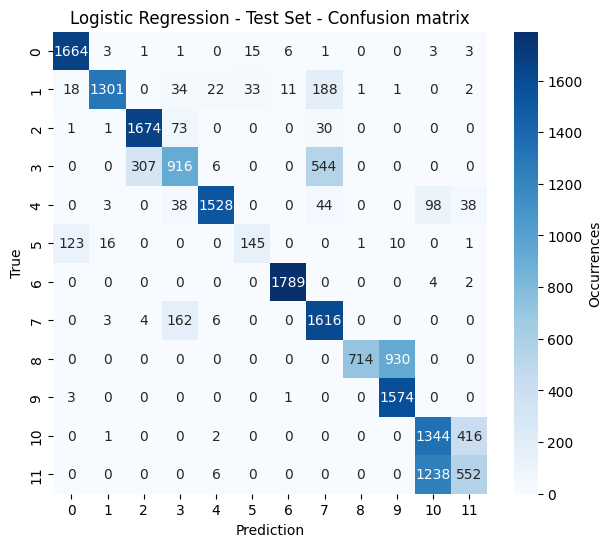

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1697
           1       0.98      0.81      0.89      1611
           2       0.84      0.94      0.89      1779
           3       0.75      0.52      0.61      1773
           4       0.97      0.87      0.92      1749
           5       0.75      0.49      0.59       296
           6       0.99      1.00      0.99      1795
           7       0.67      0.90      0.77      1791
           8       1.00      0.43      0.61      1644
           9       0.63      1.00      0.77      1578
          10       0.50      0.76      0.60      1763
          11       0.54      0.31      0.39      1796

    accuracy                           0.77     19272
   macro avg       0.79      0.75      0.75     19272
weighted avg       0.80      0.77      0.76     19272



In [ ]:
plot_confusion_matrix_and_report(y_train, y_train_pred_lr, 'Logistic Regression', 'Training Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_lr, 'Logistic Regression', 'Test Set')

## Validation Curve


### Multiclass


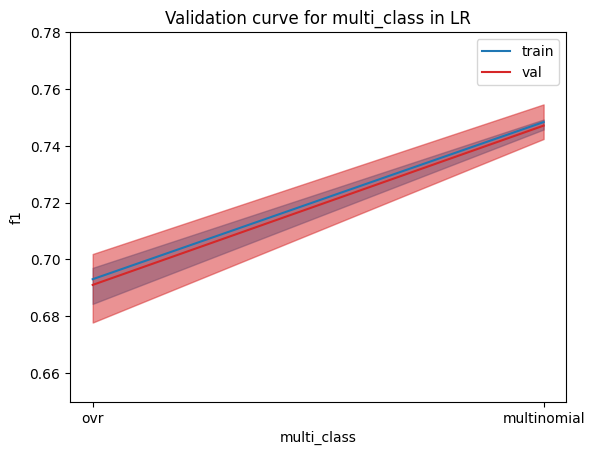

In [ ]:
from joblib import Parallel, delayed

# Define parameters
param_range = ["ovr", "multinomial"]
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Function to calculate the validation curve
def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        LogisticRegression(n_jobs=-1,random_state=42),
        X=x_train_s, y=y_train,
        param_name="multi_class",
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    return train_scores, test_scores

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

# Process the results
acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_range, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_range, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_range, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_range, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('multi_class')
plt.ylabel('f1')
plt.legend()
plt.title("Validation curve for multi_class in LR")
plt.ylim(0.65,0.78)
plt.show()


### Solver

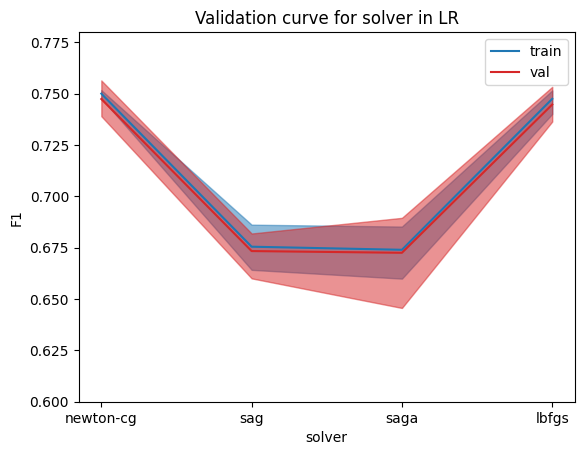

In [ ]:
from joblib import Parallel, delayed

param_range = ["newton-cg", "sag", "saga", "lbfgs"]
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Function to calculate the validation curve
def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        LogisticRegression(n_jobs=-1,random_state=42,multi_class="multinomial"),
        X=x_train_s, y=y_train,
        param_name="solver",
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    return train_scores, test_scores

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_range, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_range, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_range, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_range, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('solver')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for solver in LR")
plt.ylim(0.6,0.78)
plt.show()


### Penality


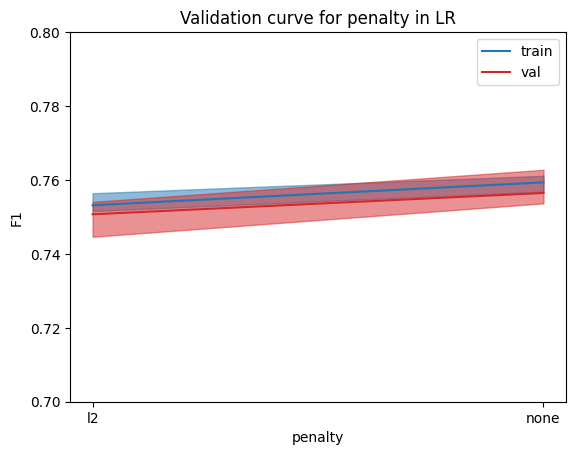

In [ ]:
param_range =  ['l2', 'none']
cv = StratifiedKFold(n_splits=5, shuffle=True)

def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        LogisticRegression(n_jobs=-1,random_state=42,multi_class="multinomial",solver="newton-cg",C=10),
        X=x_train_s, y=y_train,
        param_name="penalty",
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    return train_scores, test_scores

results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_range, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_range, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_range, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_range, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('penalty')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for penalty in LR")
plt.ylim(0.7,0.8)
plt.show()


## Randomized Search Grid


Best parameters found: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
Best cross-validation score: 0.7563350567282467


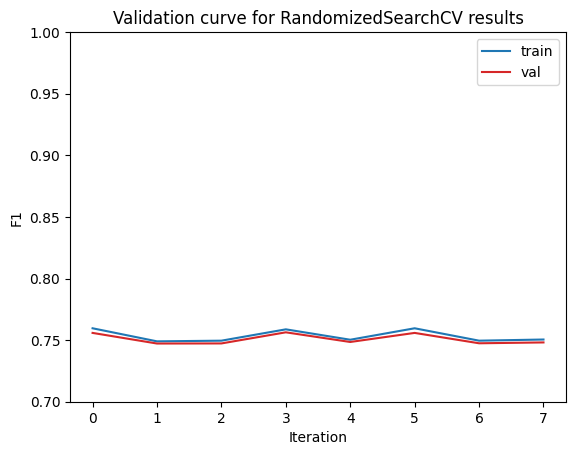

In [ ]:
param_dist = {
    'C': [1, 10, 100],
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = LogisticRegression(n_jobs=-1, random_state=42, multi_class="multinomial")

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=8,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Fit the random search model
random_search.fit(x_train_s, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Get the results
results = random_search.cv_results_
mean_train_scores = results['mean_train_score']
mean_test_scores = results['mean_test_score']

plt.figure()
plt.plot(range(len(mean_train_scores)), mean_train_scores, color='tab:blue', label='train')
plt.plot(range(len(mean_test_scores)), mean_test_scores, color='tab:red', label='val')
plt.xlabel('Iteration')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for RandomizedSearchCV results")
plt.ylim(0.7, 0.8)
plt.show()

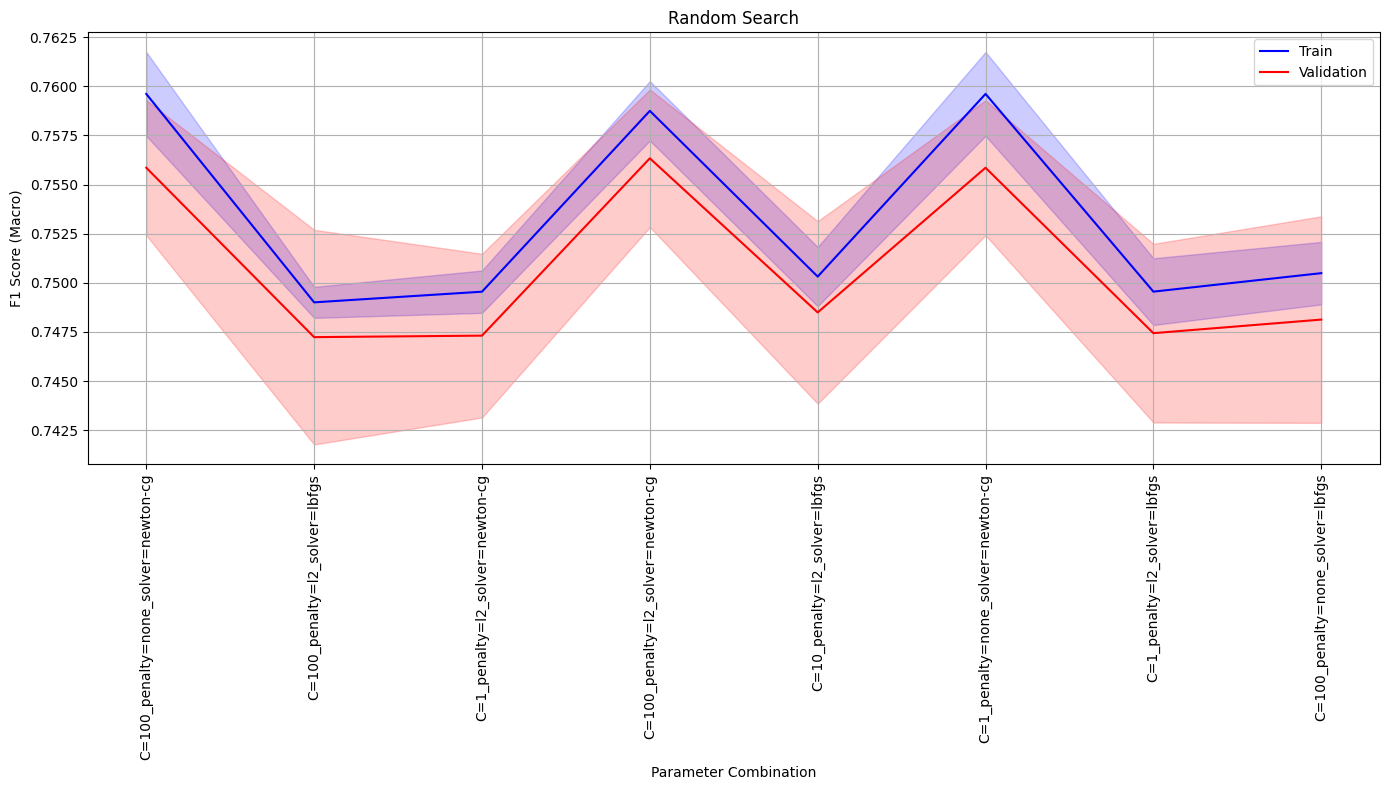

Best F1 Score (Macro): 0.7563350567282467
Parameter Combination: C=100_penalty=l2_solver=newton-cg


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the results
results = random_search.cv_results_

# Creating a DataFrame from the random search results.
results_df = pd.DataFrame(results)

# Creating an index of concatenated parameters.
results_df['param_combination'] = results_df.apply(lambda row: f"C={row.param_C}_penalty={row.param_penalty}_solver={row.param_solver}", axis=1)

# Plot the results with Matplotlib
plt.figure(figsize=(14, 8))

# Extraction of averages and standard deviations.
train_scores_mean = results_df['mean_train_score']
train_scores_std = results_df['std_train_score']
test_scores_mean = results_df['mean_test_score']
test_scores_std = results_df['std_test_score']
param_indices = range(len(results_df))

plt.plot(param_indices, train_scores_mean, label='Train', color='b')
plt.fill_between(param_indices, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='b')

plt.plot(param_indices, test_scores_mean, label='Validation', color='r')
plt.fill_between(param_indices, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='r')

plt.xticks(param_indices, results_df['param_combination'], rotation=90)
plt.xlabel('Parameter Combination')
plt.ylabel('F1 Score (Macro)')
plt.title('Random Search')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Returning the best score and its combination of parameters.
best_index = np.argmax(test_scores_mean)
best_score = test_scores_mean[best_index]
best_params = results_df.iloc[best_index]['param_combination']
print(f"Best F1 Score (Macro): {best_score}")
print(f"Parameter Combination: {best_params}")


## Analyzing Misclassifications

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Confusion Matrix:
[[1662    6    0    1    0   17    6    1    0    1    3    0]
 [  13 1335    1   34   19   34   11  160    1    1    1    1]
 [   0    3 1668   72    0    0    0   36    0    0    0    0]
 [   0    1  307  908    6    0    0  551    0    0    0    0]
 [   0    3    0   38 1624    0    0   48    0    0   25   11]
 [ 116    5    0    0    0  163    0    0    1   10    0    1]
 [   0    0    0    0    0    0 1787    0    0    0    6    2]
 [   0    3    3  137    9    0    0 1638    1    0    0    0]
 [   0    0    0    0    0    1    0    0  716  927    0    0]
 [   3    0    0    0    0    0    1    0    2 1572    0    0]
 [   0    1    0    0    1    0    0    0    0    0 1118  643]
 [   0    0    0    0    6    0    0    0    0    0 1017  773]]


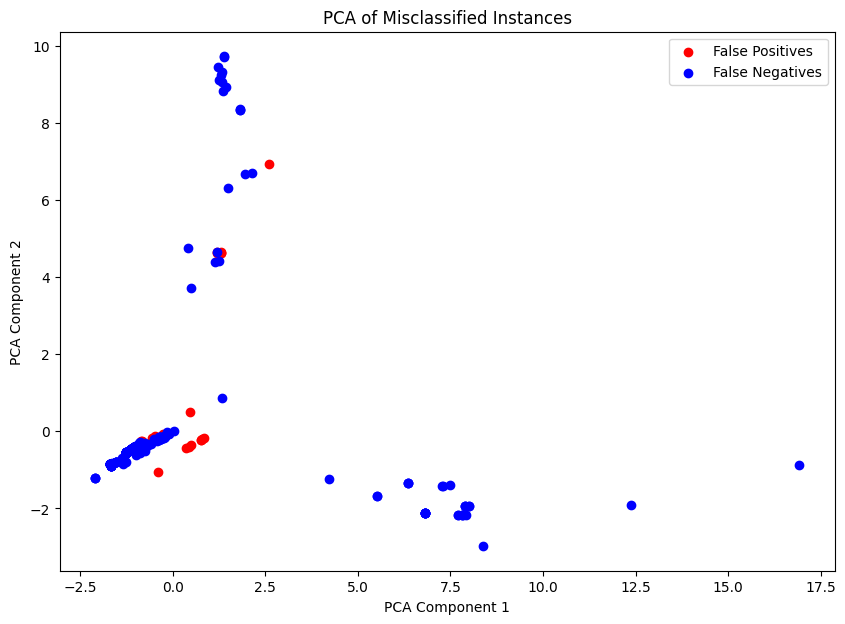

<ipython-input-9-42b5dfdba8fd>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 12)


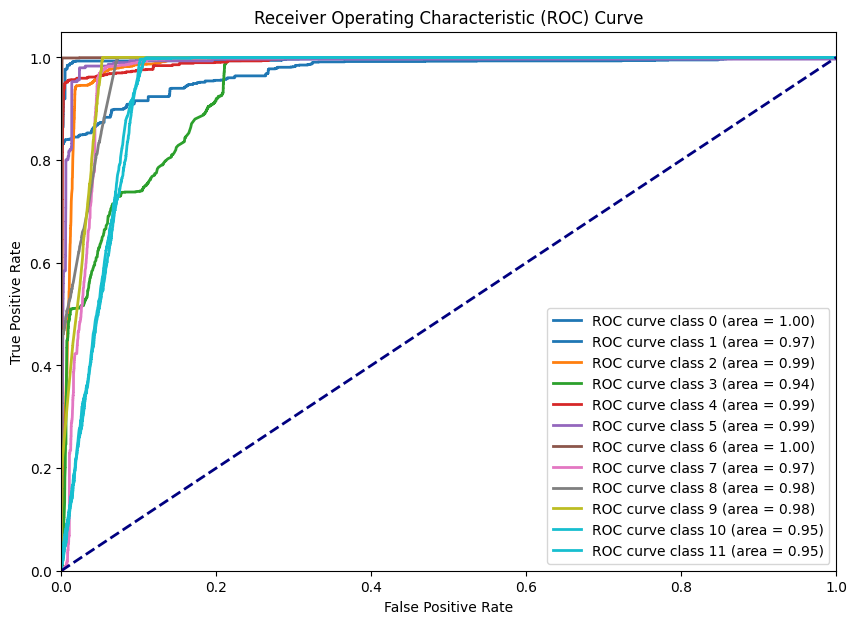

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

log_reg = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=100,penalty='l2', random_state=42)
log_reg.fit(x_train_s, y_train)
y_pred = log_reg.predict(x_test_s)
y_pred_proba = log_reg.predict_proba(x_test_s)

cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Identifies the indices of FP and FN for each class.
fp_indices = np.where((y_test != y_pred) & (y_pred == 1))[0]
fn_indices = np.where((y_test != y_pred) & (y_test == 1))[0]
fp_features = x_test_s[fp_indices]
fn_features = x_test_s[fn_indices]

# Concatenate FPs and FNs for comparison.
misclassified_features = np.concatenate((fp_features, fn_features), axis=0)
misclassified_labels = np.concatenate((np.zeros(len(fp_features)), np.ones(len(fn_features))), axis=0)

# Dimensionality reduction with PCA.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(misclassified_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[misclassified_labels == 0][:, 0], pca_result[misclassified_labels == 0][:, 1], color='red', label='False Positives')
plt.scatter(pca_result[misclassified_labels == 1][:, 0], pca_result[misclassified_labels == 1][:, 1], color='blue', label='False Negatives')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Misclassified Instances')
plt.legend()
plt.show()

# Binarize test labels for multiclass ROC curve.
y_test_binarized = label_binarize(y_test, classes=np.arange(12))

# Plot the ROC curve for each class.fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', 12)
for i, color in zip(range(12), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest


## Training with default parameters


In [ ]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(x_train_s, y_train)
y_train_pred_rf = random_forest.predict(x_train_s)
y_test_pred_rf = random_forest.predict(x_test_s)

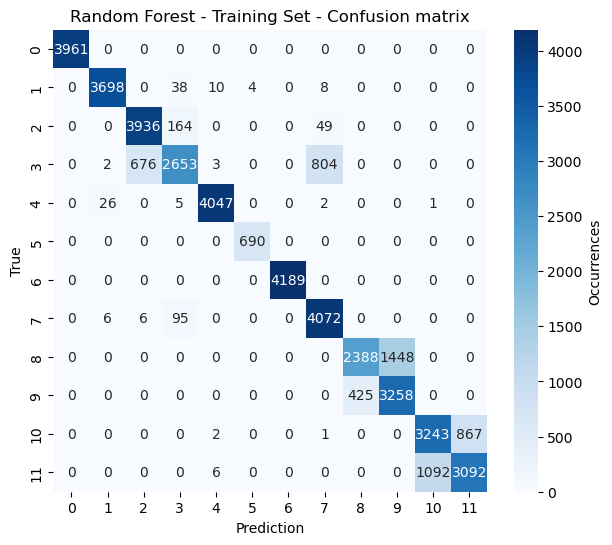

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       0.99      0.98      0.99      3758
           2       0.85      0.95      0.90      4149
           3       0.90      0.64      0.75      4138
           4       0.99      0.99      0.99      4081
           5       0.99      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       0.82      0.97      0.89      4179
           8       0.85      0.62      0.72      3836
           9       0.69      0.88      0.78      3683
          10       0.75      0.79      0.77      4113
          11       0.78      0.74      0.76      4190

    accuracy                           0.87     44967
   macro avg       0.89      0.88      0.88     44967
weighted avg       0.88      0.87      0.87     44967



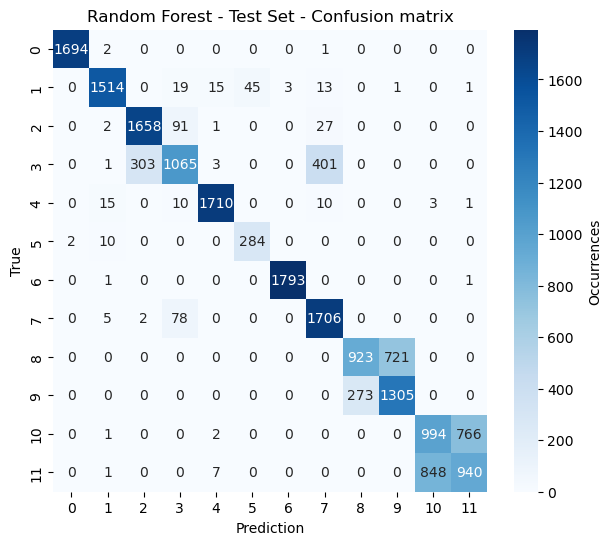

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1697
           1       0.98      0.94      0.96      1611
           2       0.84      0.93      0.89      1779
           3       0.84      0.60      0.70      1773
           4       0.98      0.98      0.98      1749
           5       0.86      0.96      0.91       296
           6       1.00      1.00      1.00      1795
           7       0.79      0.95      0.86      1791
           8       0.77      0.56      0.65      1644
           9       0.64      0.83      0.72      1578
          10       0.54      0.56      0.55      1763
          11       0.55      0.52      0.54      1796

    accuracy                           0.81     19272
   macro avg       0.82      0.82      0.81     19272
weighted avg       0.81      0.81      0.81     19272



In [ ]:
def plot_confusion_matrix_and_report(y_true, y_pred, model_name, dataset_type):
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, cbar_kws={'label': 'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{model_name} - {dataset_type} - Confusion matrix')
    os.makedirs('plots', exist_ok=True)  # Create a directory to store the plots if it doesn't exist
    plt.savefig(f'plots/{model_name}_{dataset_type}_confusion_matrix.png')
    plt.show()
    print(classification_report(y_true, y_pred))


plot_confusion_matrix_and_report(y_train, y_train_pred_rf, 'Random Forest', 'Training Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_rf, 'Random Forest', 'Test Set')


## Validation Curve

### max_depth

In [ ]:
from sklearn.model_selection import cross_validate
acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

cv = StratifiedKFold(n_splits=5, shuffle=True)
for n in range(4, 30,2):
    rf_clf = RandomForestClassifier(max_depth=n,n_jobs=-1)
    scores = cross_validate(rf_clf, x_train_s, y_train, cv=cv, scoring='f1_macro', return_train_score=True)
    acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())

(0.7, 1.0)

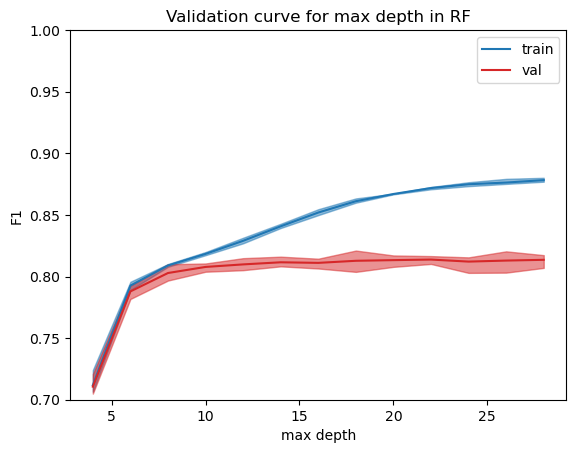

In [ ]:
plt.figure()
x = list(range(4, 30,2))
plt.plot(x, acc_train_means, color='tab:blue', label='train')
plt.fill_between(x, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(x, acc_val_means, color='tab:red', label='val')
plt.fill_between(x, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('max depth')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for max depth in RF")
plt.ylim(0.7,1)

### n_estimators

In [ ]:
# Array to store the results of cross-validation
acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

cv = StratifiedKFold(n_splits=5, shuffle=True)
for n in [50, 150, 300, 600, 1200]:
    rf_clf = RandomForestClassifier(max_depth=10,n_estimators=n,n_jobs=-1)
    scores = cross_validate(rf_clf, x_train_s, y_train, cv=cv, scoring='f1_macro', return_train_score=True)

    # Calculate statistics of interest and add them to arrays.
    acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())


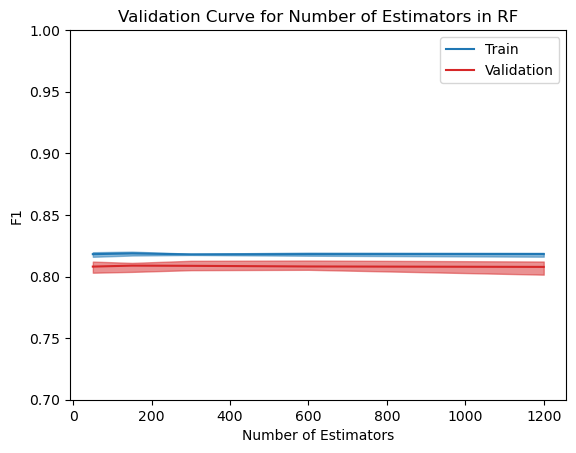

In [ ]:
plt.figure()
x = [50, 150, 300, 600, 1200]
plt.plot(x, acc_train_means, color='tab:blue', label='Train')
plt.fill_between(x, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(x, acc_val_means, color='tab:red', label='Validation')
plt.fill_between(x, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('Number of Estimators')
plt.ylabel('F1')
plt.legend()
plt.title("Validation Curve for Number of Estimators in RF")
plt.ylim(0.7, 1)
plt.show()

### min_samples_leaf

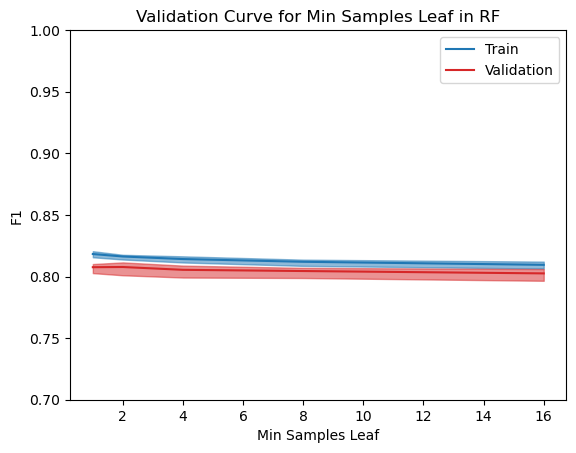

In [ ]:

# Array to store the results of cross-validation
acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

# Configure cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Values of min_samples_leaf to be evaluated.
min_samples_leaf_values = [0, 1, 2, 4, 8, 16]

for min_samples_leaf in min_samples_leaf_values:
    rf_clf = RandomForestClassifier(max_depth=10, n_estimators=150, min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=42)
    scores = cross_validate(rf_clf, x_train_s, y_train, cv=cv, scoring='f1_macro', return_train_score=True)

    # Calculate statistics of interest and add them to arrays.
        acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())

plt.figure()
plt.plot(min_samples_leaf_values, acc_train_means, color='tab:blue', label='Train')
plt.fill_between(min_samples_leaf_values, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(min_samples_leaf_values, acc_val_means, color='tab:red', label='Validation')
plt.fill_between(min_samples_leaf_values, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('Min Samples Leaf')
plt.ylabel('F1')
plt.legend()
plt.title("Validation Curve for Min Samples Leaf in RF")
plt.ylim(0.7, 1)
plt.show()



## Grid Search

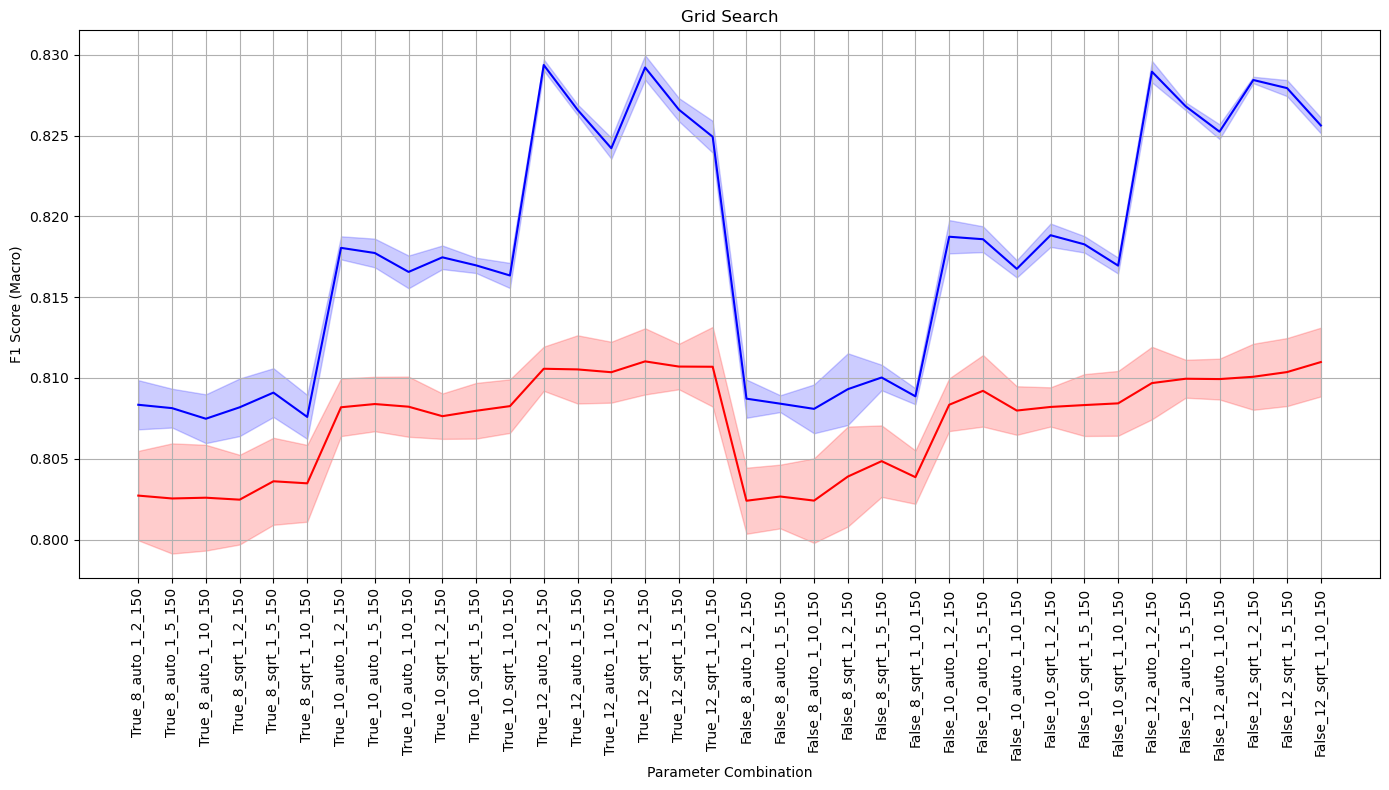

Best F1 Score (Macro): 0.8081864094324255
Parameter Combination: True_10_auto_1_2_150


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [8, 10, 12],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [150]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)
rf_clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=cv,
                           scoring=make_scorer(f1_score, average='macro'), n_jobs=-1, return_train_score=True)

grid_search.fit(x_train_s, y_train)

cv_results = grid_search.cv_results_

# Creating a DataFrame from grid search results.
results_df = pd.DataFrame(cv_results)

# Creating an index of concatenated parameters.
results_df['param_combination'] = results_df.apply(lambda row: f"{row.param_bootstrap}_{row.param_max_depth}_{row.param_max_features}_{row.param_min_samples_leaf}_{row.param_min_samples_split}_{row.param_n_estimators}", axis=1)

plt.figure(figsize=(14, 8))

train_scores_mean = results_df['mean_train_score']
train_scores_std = results_df['std_train_score']
test_scores_mean = results_df['mean_test_score']
test_scores_std = results_df['std_test_score']
param_indices = range(len(results_df))

plt.plot(param_indices, train_scores_mean, label='Train', color='b')
plt.fill_between(param_indices, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='b')

# Plot dei risultati di validation
plt.plot(param_indices, test_scores_mean, label='Validation', color='r')
plt.fill_between(param_indices, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='r')

# Setting X-axis labels with parameter combinations.
plt.xticks(param_indices, results_df['param_combination'], rotation=90)
plt.xlabel('Parameter Combination')
plt.ylabel('F1 Score (Macro)')
plt.title('Grid Search')
plt.grid(True)
plt.tight_layout()
plt.show()

# Returning the best score and its combination of parameters.
best_index = 6
best_score = test_scores_mean[best_index]
best_params = results_df.iloc[best_index]['param_combination']
print(f"Best F1 Score (Macro): {best_score}")
print(f"Parameter Combination: {best_params}")

## Analyzing Misclassifications

Confusion Matrix:
[[1694    2    0    0    0    0    0    1    0    0    0    0]
 [   0 1442    0   24   20   47    3   73    0    1    0    1]
 [   0    2 1672   76    1    0    0   28    0    0    0    0]
 [   0    1  306 1011    7    0    0  448    0    0    0    0]
 [   0   13    0    8 1704    0    0   10    0    0   11    3]
 [   3    1    0    0    1  291    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1794    0    0    0    0    1]
 [   0    2    2   75    3    0    0 1709    0    0    0    0]
 [   0    0    0    0    0    0    0    0  721  923    0    0]
 [   0    1    0    0    0    0    0    0    7 1570    0    0]
 [   0    1    0    0    4    0    0    0    0    0  950  808]
 [   0    0    0    0    7    0    0    0    0    0  746 1043]]


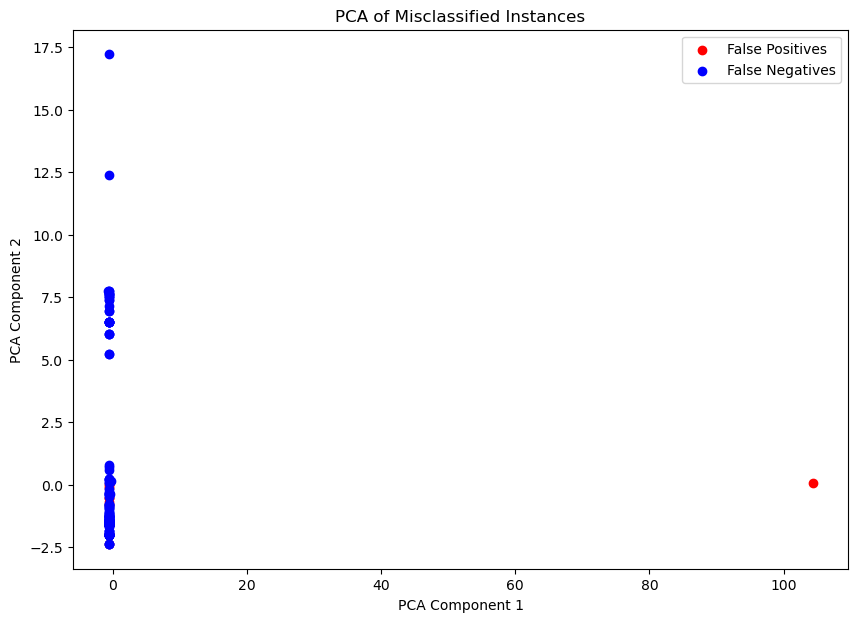

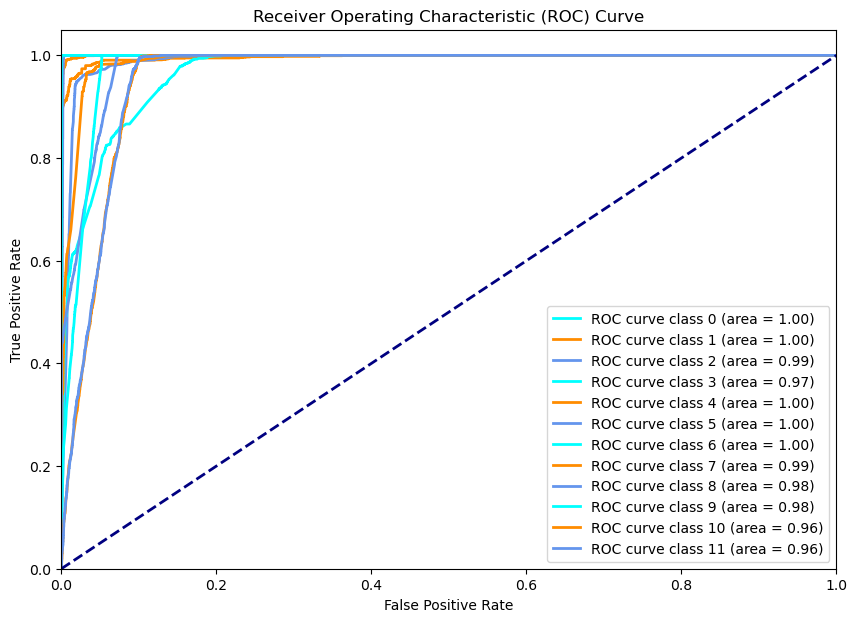

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle

rf_clf = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='auto',
                                min_samples_leaf=1, min_samples_split=2, n_estimators=150, random_state=42)
rf_clf.fit(x_train_s, y_train)

y_pred = rf_clf.predict(x_test_s)
y_pred_proba = rf_clf.predict_proba(x_test_s)

cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

fp_indices = np.where((y_test != y_pred) & (y_pred == 1))[0]
fn_indices = np.where((y_test != y_pred) & (y_test == 1))[0]

fp_features = x_test_s[fp_indices]
fn_features = x_test_s[fn_indices]

misclassified_features = np.concatenate((fp_features, fn_features), axis=0)
misclassified_labels = np.concatenate((np.zeros(len(fp_features)), np.ones(len(fn_features))), axis=0)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(misclassified_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[misclassified_labels == 0][:, 0], pca_result[misclassified_labels == 0][:, 1], color='red', label='False Positives')
plt.scatter(pca_result[misclassified_labels == 1][:, 0], pca_result[misclassified_labels == 1][:, 1], color='blue', label='False Negatives')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Misclassified Instances')
plt.legend()
plt.show()

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Support Vector Machines


## Training with default parameters

In [ ]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(x_train_s, y_train)
y_train_pred_svm = svm_classifier.predict(x_train_s)
y_test_pred_svm = svm_classifier.predict(x_test_s)


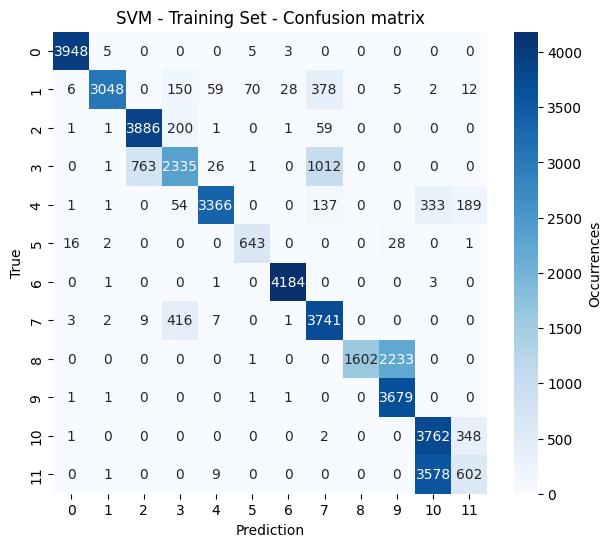

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3961
           1       1.00      0.81      0.89      3758
           2       0.83      0.94      0.88      4149
           3       0.74      0.56      0.64      4138
           4       0.97      0.82      0.89      4081
           5       0.89      0.93      0.91       690
           6       0.99      1.00      1.00      4189
           7       0.70      0.90      0.79      4179
           8       1.00      0.42      0.59      3836
           9       0.62      1.00      0.76      3683
          10       0.49      0.91      0.64      4113
          11       0.52      0.14      0.23      4190

    accuracy                           0.77     44967
   macro avg       0.81      0.79      0.77     44967
weighted avg       0.80      0.77      0.76     44967



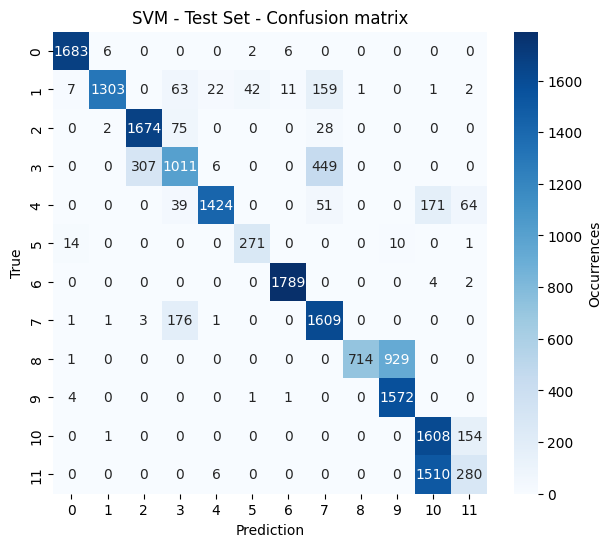

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1697
           1       0.99      0.81      0.89      1611
           2       0.84      0.94      0.89      1779
           3       0.74      0.57      0.64      1773
           4       0.98      0.81      0.89      1749
           5       0.86      0.92      0.89       296
           6       0.99      1.00      0.99      1795
           7       0.70      0.90      0.79      1791
           8       1.00      0.43      0.61      1644
           9       0.63      1.00      0.77      1578
          10       0.49      0.91      0.64      1763
          11       0.56      0.16      0.24      1796

    accuracy                           0.78     19272
   macro avg       0.81      0.79      0.77     19272
weighted avg       0.81      0.78      0.76     19272



In [ ]:
plot_confusion_matrix_and_report(y_train, y_train_pred_svm, 'SVM', 'Training Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_svm, 'SVM', 'Test Set')

## Hyperparameter tuning


### Kernel


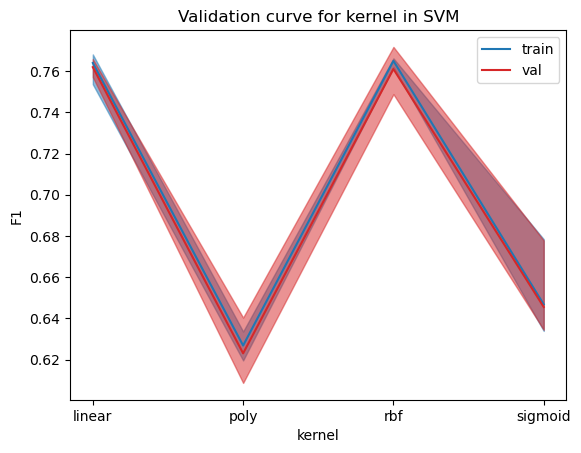

In [ ]:
param_range = ['linear','poly', 'rbf', 'sigmoid']
cv = StratifiedKFold(n_splits=5, shuffle=True)

def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        SVC(random_state=42),
        X=x_train_s, y=y_train,
        param_name='kernel',
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=1
    )
    return train_scores, test_scores

results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_range, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_range, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_range, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_range, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('kernel')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for kernel in SVM")
plt.ylim(0.7,0.8)
plt.show()


### C

0.001
10
1


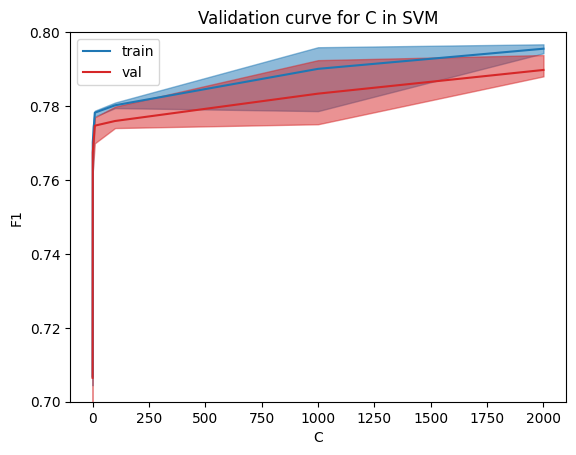

0.01
1
0.1


In [ ]:
from joblib import Parallel, delayed

param_range = [0.1, 1, 10, 100, 1000, 2000]
cv = StratifiedKFold(n_splits=5, shuffle=True)

def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        SVC(random_state=42,kernel='rbf'),
        X=x_train_s, y=y_train,
        param_name="C",
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    print(param)
    return train_scores, test_scores

results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_range, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_range, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_range, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_range, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('C')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for C in SVM")
plt.ylim(0.7,0.8)
plt.show()


### Gamma

0.0001


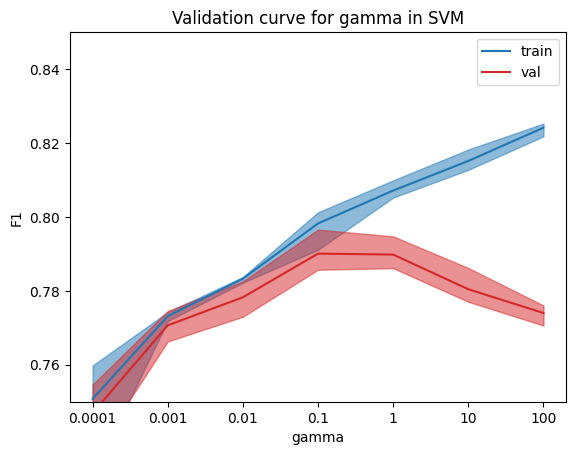

In [ ]:
from sklearn.model_selection import validation_curve, StratifiedKFold
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

param_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
param_indices = range(len(param_range))  # Numerical indices for plotting

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def compute_validation_curve(param):
    train_scores, test_scores = validation_curve(
        SVC(random_state=42, kernel='rbf', C=1000),
        X=x_train_s, y=y_train,
        param_name="gamma",
        param_range=[param],
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    print(param)
    return train_scores, test_scores

results = Parallel(n_jobs=-1)(delayed(compute_validation_curve)(param) for param in param_range)

acc_train_means = [np.mean(result[0]) for result in results]
acc_train_maxs = [np.max(result[0]) for result in results]
acc_train_mins = [np.min(result[0]) for result in results]
acc_val_means = [np.mean(result[1]) for result in results]
acc_val_maxs = [np.max(result[1]) for result in results]
acc_val_mins = [np.min(result[1]) for result in results]

plt.figure()
plt.plot(param_indices, acc_train_means, color='tab:blue', label='train')
plt.fill_between(param_indices, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(param_indices, acc_val_means, color='tab:red', label='val')
plt.fill_between(param_indices, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('gamma')
plt.ylabel('F1')
plt.legend()
plt.title("Validation curve for gamma in SVM")
plt.ylim(0.75, 0.85)
plt.xticks(param_indices, param_range)  # Set x-ticks to the original param_range values
plt.show()


### Performance evaluation of tuning

In [17]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import f1_score

svm_classifier = SVC(random_state=42, kernel='rbf', C=1000, gamma=0.1)
svm_classifier.fit(x_train_s, y_train)
y_train_pred = svm_classifier.predict(x_train_s)
y_test_pred = svm_classifier.predict(x_test_s)

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')


print(f"Average F1 Score (Training): {f1_train}")
print(f"Average F1 Score (Test): {f1_test}")
print(f"Parameter Combination: kernel=rbf, C=1000, gamma=0.1 (Used in this run)")
svm_classifier.fit(x_train_s, y_train)


Average F1 Score (Training): 0.7994878524579546
Average F1 Score (Test): 0.7958686795979264
Parameter Combination: kernel=rbf, C=1000, gamma=0.1 (Used in this run)


SVC(C=1000, gamma=0.1, random_state=42)

## Analyzing Misclassifications

Confusion Matrix:
[[1693    1    0    0    0    1    2    0    0    0    0    0]
 [   6 1418    0   19   16   41    7  103    0    0    0    1]
 [   2    1 1673   75    0    0    0   28    0    0    0    0]
 [   0    1  307  992    6    0    0  467    0    0    0    0]
 [   0    2    0   30 1624    0    0   58    0    0   31    4]
 [   5    9    0    0    1  280    0    0    0    1    0    0]
 [   0    0    0    0    0    0 1789    0    0    0    4    2]
 [   1    5    2   62    6    0    0 1715    0    0    0    0]
 [   5    0    0    0    0    0    0    0  711  928    0    0]
 [   3    1    0    0    0    0    0    0    0 1574    0    0]
 [   0    1    0    0    3    0    0    0    0    0 1336  423]
 [   0    0    0    0    7    0    0    0    0    0 1231  558]]


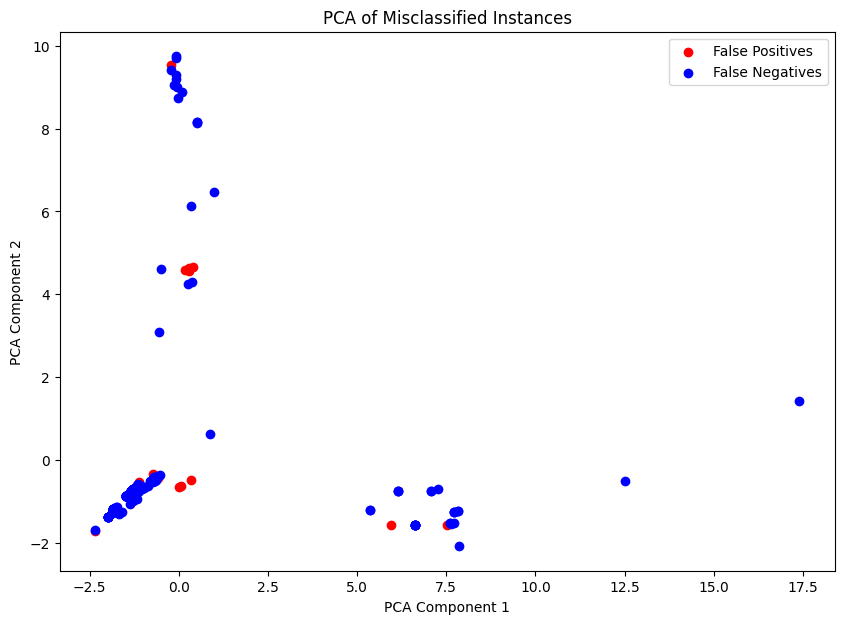

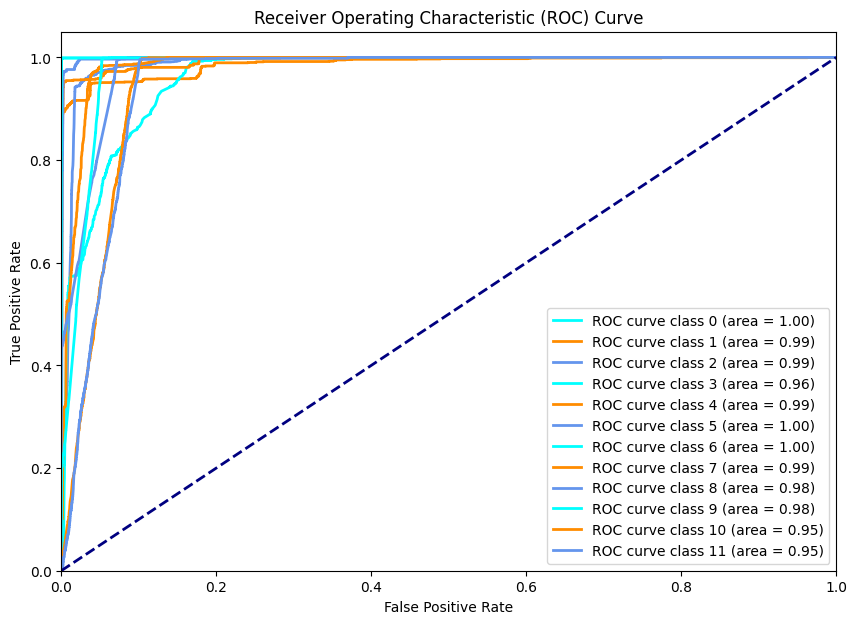

In [27]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# Example placeholders for your dataset division
# x_train_s, y_train, x_test_s, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

svm_classifier = SVC(random_state=42, kernel='rbf', C=1000, gamma=0.1, probability=True)
svm_classifier.fit(x_train_s, y_train)
y_pred = svm_classifier.predict(x_test_s)
y_pred_proba = svm_classifier.predict_proba(x_test_s)  # Correct method to get probabilities

cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Identifying false positives and false negatives
fp_indices = np.where((y_test != y_pred) & (y_pred == 1))[0]
fn_indices = np.where((y_test != y_pred) & (y_test == 1))[0]

fp_features = x_test_s[fp_indices]
fn_features = x_test_s[fn_indices]

misclassified_features = np.concatenate((fp_features, fn_features), axis=0)
misclassified_labels = np.concatenate((np.zeros(len(fp_features)), np.ones(len(fn_features))), axis=0)

# Performing PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(misclassified_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[misclassified_labels == 0][:, 0], pca_result[misclassified_labels == 0][:, 1], color='red', label='False Positives')
plt.scatter(pca_result[misclassified_labels == 1][:, 0], pca_result[misclassified_labels == 1][:, 1], color='blue', label='False Negatives')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Misclassified Instances')
plt.legend()
plt.show()

# Binarizing the labels if not binary
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
if y_test_binarized.ndim == 1:
    y_test_binarized = y_test_binarized.reshape(-1, 1)

fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_binarized.shape[1]

# Calculating ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
